Use conda environment conda_envs/cool_env.yml to run this notebook.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bbi
import pybedtools as pbt
import cooler
from matplotlib_venn import venn2
from matplotlib_venn import venn2_unweighted 

Uploading of contact maps and defining regions with NaN values of contact frequency

In [9]:
clr_en = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')
clr_in = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')

In [10]:
all_white = []
chroms = [c.values[0] for c in clr_en.chroms()['name']]
clrs = [clr_en, clr_in]
for clr in clrs:
    for chrom in chroms:
        white_for_1chrom = clr.bins().fetch(chrom)[np.isnan(clr.bins().fetch(chrom)['weight'])].reset_index()
        all_white.append(white_for_1chrom)
all_white_bins = pd.concat(all_white)[['chrom', 'start', 'end']].sort_values(by=['chrom', 'start']).drop_duplicates().reset_index(drop=True)
allwhitebins = pbt.BedTool.from_dataframe(all_white_bins)
all_white_bins = allwhitebins.merge().to_dataframe()
all_white_bins['start'] = np.where((all_white_bins['start'] - 50000) > 0, all_white_bins['start'] - 50000, 0)
all_white_bins['end'] = all_white_bins['end'] + 50000
allwhitebins = pbt.BedTool.from_dataframe(all_white_bins)

In [11]:
blacklist = pd.read_csv('/path/to/data/hg38-blacklist.v2.bed.gz', sep='\t', header=None)
blacklist = blacklist.rename(columns={0: 'chrom', 1: 'start', 2: 'end', 3: 'quality'})
blacklist_pbt = pbt.BedTool.from_dataframe(blacklist)

Uploading CTCF peaks and Polycomb-mediated contacts coordinates and excluding ones within empty regions of contact maps

In [12]:
ctcf_peaks = pd.read_csv('/path/to/data/CTCF_DLPFC-NEUN_idr.optimal_peak.regionPeak.gz', sep='\t', header=None).rename(columns={0: 'chrom', 1: 'start', 2: 'end'})[['chrom', 'start', 'end']]
ctcf_peaks_pbt = pbt.BedTool.from_dataframe(ctcf_peaks)
ctcf_bw_path = '/path/to/data/CTCF_DLPFC-NEUN_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig'
polycomb_anch = pd.read_csv("/path/to/data/polycomb_dot_anchors.5kb.16_06_25.csv")
polycomb_anch[['start', 'end']] = polycomb_anch[['start', 'end']].astype(int)
polycomb_anch_pbt = pbt.BedTool.from_dataframe(polycomb_anch)

In [13]:
ctcf_clean = ctcf_peaks_pbt.intersect(allwhitebins, c=True).intersect(blacklist_pbt, c=True).to_dataframe(names=['chrom', 'start', 'end', 'white', 'black'])
ctcf_clean = ctcf_clean[(ctcf_clean['white'] == 0) & (ctcf_clean['black'] == 0)]
ctcf_clean_pbt = pbt.BedTool.from_dataframe(ctcf_clean)

Defining group sizes for Venn diagram

In [14]:
print(len(ctcf_clean))
print(len(polycomb_anch))

38438
262


In [15]:
plc_ctcf_overlap = polycomb_anch_pbt.intersect(ctcf_clean_pbt, c=True).to_dataframe(names=['chrom', 'start', 'end', 'ctcf'])

In [16]:
plc_ctcf_overlap.groupby('ctcf').size()

ctcf
0     156
1      48
2      32
3      12
4       7
5       3
6       3
12      1
dtype: int64

In [17]:
print(len(plc_ctcf_overlap[plc_ctcf_overlap['ctcf'] > 0]))

106


/home/kuzn_rina/.conda/envs/coolclone/lib/python3.10/site-packages/matplotlib_venn/_util.py:32: UserWarning: venn2_unweighted is deprecated. Use venn2 with the appropriate layout_algorithm instead.
  warnings.warn(


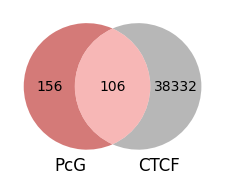

In [19]:
plt.figure(figsize=(3, 2))
venn2_unweighted(subsets=(156, 38332, 106), 
      set_labels=('PcG', 'CTCF'), 
      set_colors=('#c3423f', '#999999'), 
      alpha=0.7)

plt.savefig('pcg_ctcf_venn.pdf', format='pdf', bbox_inches='tight')
plt.show()

Calculation of the average ChIP-seq signal per bin for regions within a 20 kb radius from the center of the peak or polycomb-mediated contact

In [25]:
polycomb_stackup = {}
polycomb_sem = {}

offset, nbins = 20000, 100

plot_df = polycomb_anch.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset

s = bbi.stackup(ctcf_bw_path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
polycomb_stackup = np.mean(s, axis=0)
polycomb_sem = np.std(s, axis=0) / np.sqrt(len(s))

In [26]:
ctcf_stackup = {}
ctcf_sem = {}

plot_df = ctcf_clean.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset

s = bbi.stackup(ctcf_bw_path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
ctcf_stackup = np.mean(s, axis=0)
ctcf_sem = np.std(s, axis=0) / np.sqrt(len(s))

/tmp/ipykernel_3444061/3477518073.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.001)


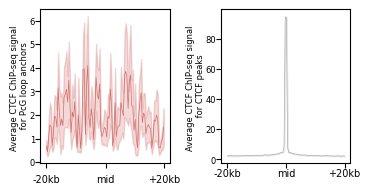

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (4, 2), gridspec_kw={'wspace': 0.4})

axs[0].plot(range(0, 100), polycomb_stackup, alpha=0.7, color = '#c3423f', linewidth=0.5)
axs[0].set_ylabel('Average CTCF ChIP-seq signal \n for PcG loop anchors', fontsize=6, labelpad=0.05)  
axs[0].fill_between(range(0, 100),
                polycomb_stackup - polycomb_sem, 
                polycomb_stackup + polycomb_sem, color='#c3423f', alpha=0.2)

ticks = [0, nbins // 2, nbins - 1]
labels = ['-20kb', 'mid', '+20kb']
axs[0].set_xticks(ticks)
axs[0].set_xticklabels([])
axs[0].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[0].text(tick, -0.5, label, ha='center', va='top', fontsize=7)

axs[1].plot(range(0, 100), ctcf_stackup, alpha=0.7, color = '#999999', linewidth=0.5)
axs[1].set_ylabel('Average CTCF ChIP-seq signal \n for CTCF peaks', fontsize=6, labelpad=0)  
axs[1].fill_between(range(0, 100),
                ctcf_stackup - ctcf_sem, 
                ctcf_stackup + ctcf_sem, color='#999999', alpha=0.2)

labels = ['-20kb', 'mid', '+20kb']
axs[1].set_xticks(ticks)
axs[1].set_xticklabels([])
axs[1].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[1].text(tick, -6, label, ha='center', va='top', fontsize=7)

plt.tight_layout(pad=0.001)
plt.savefig('chip_ctcf_signal_for_interval.pdf', format='pdf', bbox_inches='tight')
plt.show()

Calculation of the average ChIP-seq signal per bin for full-size polycomb-mediated contact regions

In [29]:
polycomb_stackup = {}
polycomb_sem = {}

plot_df = polycomb_anch.reset_index(drop=True)

s = bbi.stackup(ctcf_bw_path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
polycomb_stackup = np.mean(s, axis=0)
polycomb_sem = np.std(s, axis=0) / np.sqrt(len(s))

/tmp/ipykernel_3444061/1361936650.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.001)


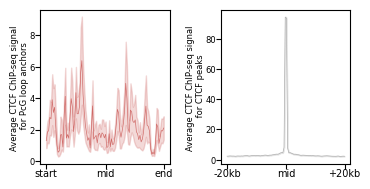

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (4, 2), gridspec_kw={'wspace': 0.4})

axs[0].plot(range(0, 100), polycomb_stackup, alpha=0.7, color = '#c3423f', linewidth=0.5)
axs[0].set_ylabel('Average CTCF ChIP-seq signal \n for PcG loop anchors', fontsize=6, labelpad=0.05)  
axs[0].fill_between(range(0, 100),
                polycomb_stackup - polycomb_sem, 
                polycomb_stackup + polycomb_sem, color='#c3423f', alpha=0.2)

ticks = [0, nbins // 2, nbins - 1]
labels = ['start', 'mid', 'end']
axs[0].set_xticks(ticks)
axs[0].set_xticklabels([])
axs[0].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[0].text(tick, -0.5, label, ha='center', va='top', fontsize=7)

axs[1].plot(range(0, 100), ctcf_stackup, alpha=0.7, color = '#999999', linewidth=0.5)
axs[1].set_ylabel('Average CTCF ChIP-seq signal \n for CTCF peaks', fontsize=6, labelpad=0)  
axs[1].fill_between(range(0, 100),
                ctcf_stackup - ctcf_sem, 
                ctcf_stackup + ctcf_sem, color='#999999', alpha=0.2)

labels = ['-20kb', 'mid', '+20kb']
axs[1].set_xticks(ticks)
axs[1].set_xticklabels([])
axs[1].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[1].text(tick, -6, label, ha='center', va='top', fontsize=7)

plt.tight_layout(pad=0.001)
plt.savefig('chip_ctcf_signal_for_contact_regions.pdf', format='pdf', bbox_inches='tight')
plt.show()

Uploading loop coordinates defined on 2kb and 5kb resolutions for EN and IN contact maps

In [31]:
en_2kb_loops = pd.read_csv('/path/to/data/EN_2kb_loops.bed', sep = '\t')
en_5kb_loops = pd.read_csv('/path/to/data/EN_5kb_loops.bed', sep = '\t')
in_2kb_loops = pd.read_csv('/path/to/data/IN_2kb_loops.bed', sep = '\t')
in_5kb_loops = pd.read_csv('/path/to/data/IN_5kb_loops.bed', sep = '\t')

In [32]:
loops_merged = pd.concat([en_2kb_loops, en_5kb_loops, in_2kb_loops, in_5kb_loops]).sort_values(by = ['chrom1', 'start1', 'end1'])
loops_merged = loops_merged[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']].drop_duplicates().reset_index(drop=True)

In [33]:
loop_anchors = pd.concat([loops_merged[['chrom1', 'start1', 'end1']].rename(columns={'chrom1': 'chrom', 'start1': 'start', 'end1': 'end'}), loops_merged[['chrom2', 'start2', 'end2']].rename(columns={'chrom2': 'chrom', 'start2': 'start', 'end2': 'end'})])

In [34]:
loop_anchors = loop_anchors.drop_duplicates().reset_index(drop=True)

In [35]:
loop_anchors_pbt = pbt.BedTool.from_dataframe(loop_anchors)

Defining overlaps between CTCF peaks and loop coordinates

In [36]:
ctcf_loops = ctcf_clean_pbt.intersect(loop_anchors_pbt, c=True).to_dataframe(names = ['chrom', 'start', 'end', 'white', 'black', 'loop'])
ctcf_loops = ctcf_loops[ctcf_loops['loop'] > 0].reset_index(drop=True)

In [37]:
ctcf_loops_pbt = pbt.BedTool.from_dataframe(ctcf_loops)

In [124]:
offset, nbins = 20000, 100
ctcf_stackup = {}
ctcf_sem = {}

plot_df = ctcf_loops.reset_index(drop=True)
plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
plot_df['start'] = plot_df['mid'] - offset
plot_df['end'] = plot_df['mid'] + offset

s = bbi.stackup(ctcf_bw_path, plot_df['chrom'], plot_df['start'], plot_df['end'], bins=nbins)
ctcf_stackup = np.mean(s, axis=0)
ctcf_sem = np.std(s, axis=0) / np.sqrt(len(s))

/tmp/ipykernel_3444061/933493499.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.001)


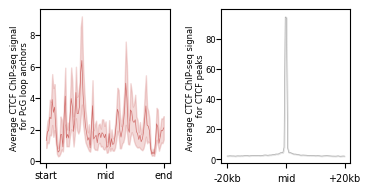

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (4, 2), gridspec_kw={'wspace': 0.4})

axs[0].plot(range(0, 100), polycomb_stackup, alpha=0.7, color = '#c3423f', linewidth=0.5)
axs[0].set_ylabel('Average CTCF ChIP-seq signal \n for PcG loop anchors', fontsize=6, labelpad=0.05)  
axs[0].fill_between(range(0, 100),
                polycomb_stackup - polycomb_sem, 
                polycomb_stackup + polycomb_sem, color='#c3423f', alpha=0.2)

ticks = [0, nbins // 2, nbins - 1]
labels = ['start', 'mid', 'end']
axs[0].set_xticks(ticks)
axs[0].set_xticklabels([])
axs[0].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[0].text(tick, -0.6, label, ha='center', va='top', fontsize=7)

axs[1].plot(range(0, 100), ctcf_stackup, alpha=0.7, color = '#999999', linewidth=0.5)
axs[1].set_ylabel('Average CTCF ChIP-seq signal \n for CTCF peaks', fontsize=6, labelpad=0)  
axs[1].fill_between(range(0, 100),
                ctcf_stackup - ctcf_sem, 
                ctcf_stackup + ctcf_sem, color='#999999', alpha=0.2)

labels = ['-20kb', 'mid', '+20kb']
axs[1].set_xticks(ticks)
axs[1].set_xticklabels([])
axs[1].tick_params(axis='y', labelsize=6, pad=0.5)

for tick, label in zip(ticks, labels):
    axs[1].text(tick, -9, label, ha='center', va='top', fontsize=7)

plt.tight_layout(pad=0.001)
plt.savefig('chip_ctcf_with_loops_signal.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [39]:
plc_ctcf_loop_overlap = polycomb_anch_pbt.intersect(ctcf_loops_pbt, c=True).to_dataframe(names=['chrom', 'start', 'end', 'ctcf'])

In [40]:
len(polycomb_anch)

262

In [41]:
len(ctcf_loops)

32614

In [42]:
len(plc_ctcf_loop_overlap[plc_ctcf_loop_overlap['ctcf'] > 0])

101

/home/kuzn_rina/.conda/envs/coolclone/lib/python3.10/site-packages/matplotlib_venn/_util.py:32: UserWarning: venn2_unweighted is deprecated. Use venn2 with the appropriate layout_algorithm instead.
  warnings.warn(


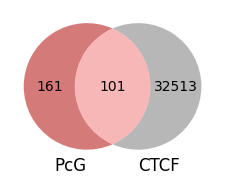

In [43]:
plt.figure(figsize=(3, 2))
venn2_unweighted(subsets=(161, 32513, 101), 
      set_labels=('PcG', 'CTCF'), 
      set_colors=('#c3423f', '#999999'), 
      alpha=0.7)

plt.savefig('pcg_ctcf_venn_with_loops.pdf', format='pdf', bbox_inches='tight')
plt.show()